# Melanoma Detection:
Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing all the important libraries

In [101]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
from glob import glob
import Augmentor
import keras
from keras.models import Model

In [102]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Importing Skin Cancer Data

In [103]:
# Defining the path for train and test images
Train_data_path = "Skin_cancer_data/Train/"
Test_data_path = "Skin_cancer_data/Test/"

data_dir_train = pathlib.Path(Train_data_path)
data_dir_test = pathlib.Path(Test_data_path)

In [104]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [105]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

#### Load data using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [106]:
# Dataset for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Train_data_path,
    labels='inferred',
    label_mode='int', #'categorical',
    #class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format= 'channels_last',
    verbose=True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [107]:
# Dataset for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Train_data_path,
    labels='inferred',
    label_mode='int', #'categorical',
    #class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format= 'channels_last',
    verbose=True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Class names from dataaset

In [108]:

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

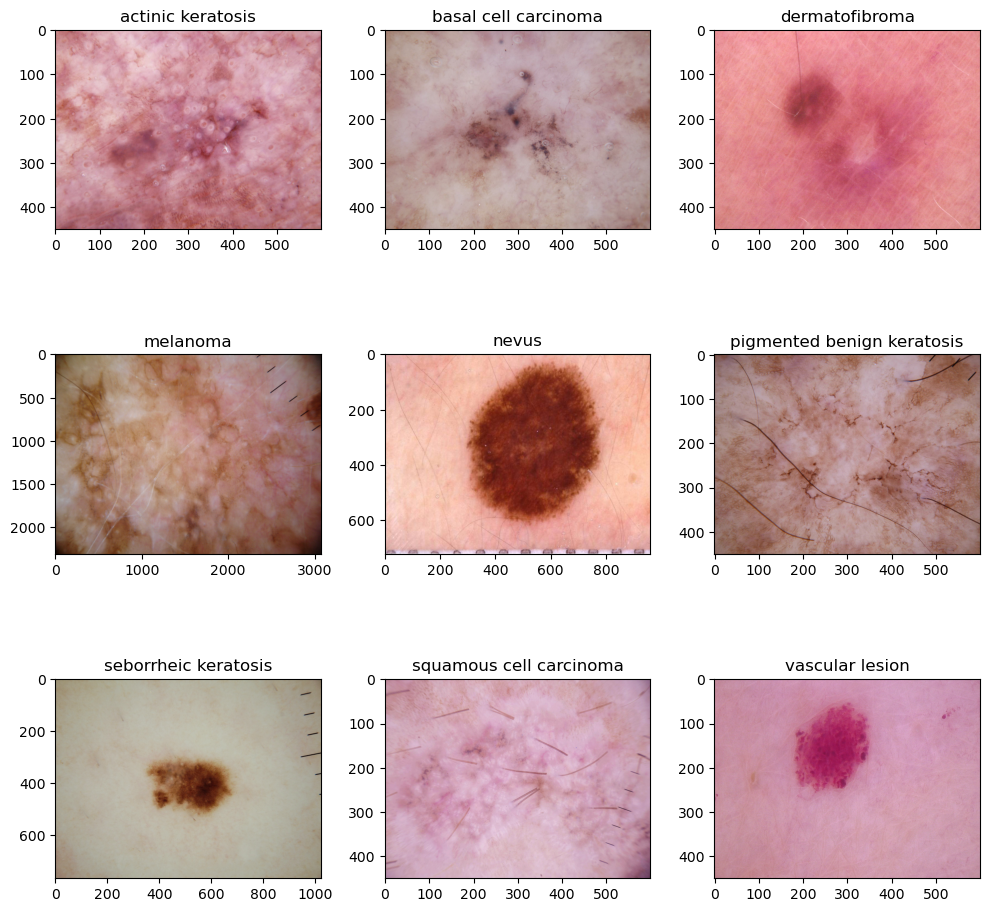

In [109]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    
    filenames = os.listdir(os.path.join(Train_data_path, class_names[i]))
    image = Image.open(os.path.join(Train_data_path, class_names[i],random.choice(filenames) ))
    
    ax.imshow(np.asarray(image).astype("uint8"))
    ax.set_title(class_names[i])

plt.tight_layout()
plt.show()

In [110]:
# Validate dimentions of input and labels for one batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [111]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model:

#### Normalization layer:

The input image is a color image and each pixel value ranges from 0 to 255. To rescale image pixel values we use normalization layer as follows.

In [112]:

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0019607844 1.0


### Build model v1:

In [113]:
num_classes = 9

model_v1 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding="same",activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [114]:
### Todo, choose an appropirate optimiser and loss function
model_v1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [115]:
# View the summary of all layers
model_v1.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_24 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2048)           │    63,440,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,518,185 (246.12 MB)

 Trainable params: 64,518,185 (246.12 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [16]:
epochs = 20
history = model_v1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 893ms/step - accuracy: 0.1853 - loss: 3.6033 - val_accuracy: 0.2483 - val_loss: 1.9290
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 860ms/step - accuracy: 0.2952 - loss: 1.9189 - val_accuracy: 0.4094 - val_loss: 1.5917
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 859ms/step - accuracy: 0.4192 - loss: 1.6338 - val_accuracy: 0.4832 - val_loss: 1.4695
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 860ms/step - accuracy: 0.5093 - loss: 1.3909 - val_accuracy: 0.4966 - val_loss: 1.4067
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 868ms/step - accuracy: 0.5293 - loss: 1.3120 - val_accuracy: 0.5347 - val_loss: 1.3279
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 867ms/step - accuracy: 0.5771 - loss: 1.1940 - val_accuracy: 0.5436 - val_loss: 1.3747
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 871ms/step - accuracy: 0.5941 - loss: 1.1363 - val_accuracy: 0.5302 - val_loss: 1.4174
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 871ms/step - accuracy: 0.6300 - loss: 1.0243 - val_accu

#### Visualizing training results

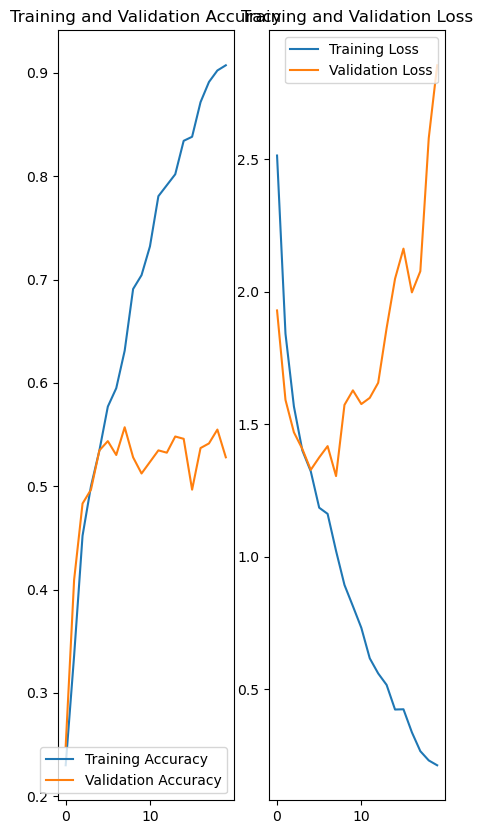

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(5, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings from model_v1:

 - From the accuracy plot we can observe that model accuracy is high for training and low for validation. So the current model is overfitting for given data.
 - To solve this problem we can do regularization methods on model architecture.

#### Data augmentation:

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.25), # Rotating image with factor of 25% of 2pi [-25% * 2pi, 25% * 2pi]
  layers.RandomBrightness(0.3, value_range=(0, 255))
])

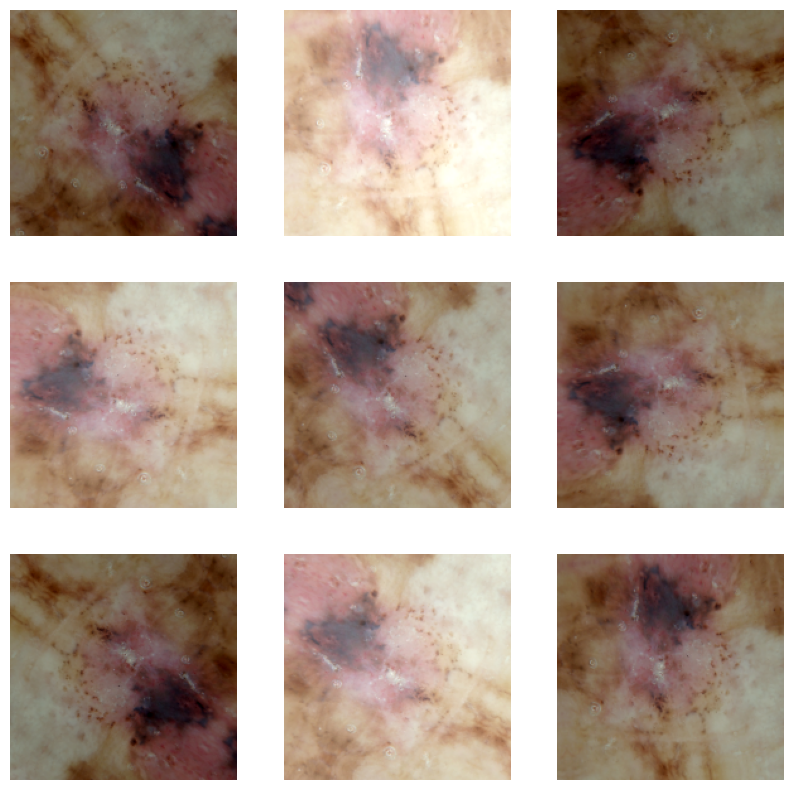

In [19]:
# Visualizing data augmentation Strategy
image_batch, label_batch = next(iter(train_ds))
first_image = image_batch[0]
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(first_image)
  ax = plt.subplot(3, 3, i + 1)
  outimage = augmented_image.numpy()
  plt.imshow(outimage.astype('uint8') )
  plt.axis("off")
    


### Build Model_v2:
Build CNN classification model with regularization layers(dropout).


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model_v2 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),
  tf.keras.layers.Rescaling(1./255),
  #layers.RandomFlip("horizontal_and_vertical"),  # Augmentation layer fplipping
  #layers.RandomRotation(0.25),  # Augmentation layer rotation
  tf.keras.layers.Conv2D(16, 3, padding="same",activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])



#### Compiling the model

In [21]:
## Your code goes here
model_v2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_v2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 865ms/step - accuracy: 0.2072 - loss: 2.8209 - val_accuracy: 0.3781 - val_loss: 1.7736
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 862ms/step - accuracy: 0.3422 - loss: 1.8029 - val_accuracy: 0.4340 - val_loss: 1.5973
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 863ms/step - accuracy: 0.4690 - loss: 1.5244 - val_accuracy: 0.4743 - val_loss: 1.5128
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 863ms/step - accuracy: 0.4941 - loss: 1.4078 - val_accuracy: 0.5213 - val_loss: 1.3936
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 864ms/step - accuracy: 0.5636 - loss: 1.2586 - val_accuracy: 0.5257 - val_loss: 1.4001
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 863ms/step - accuracy: 0.5916 - loss: 1.1323 - val_accuracy: 0.5257 - val_loss: 1.4301
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 870ms/step - accuracy: 0.6413 - loss: 1.0203 - val_accuracy: 0.5369 - val_loss: 1.3390
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 862ms/step - accuracy: 0.6605 - loss: 0.9453 - val_accu

#### Visualizing the results

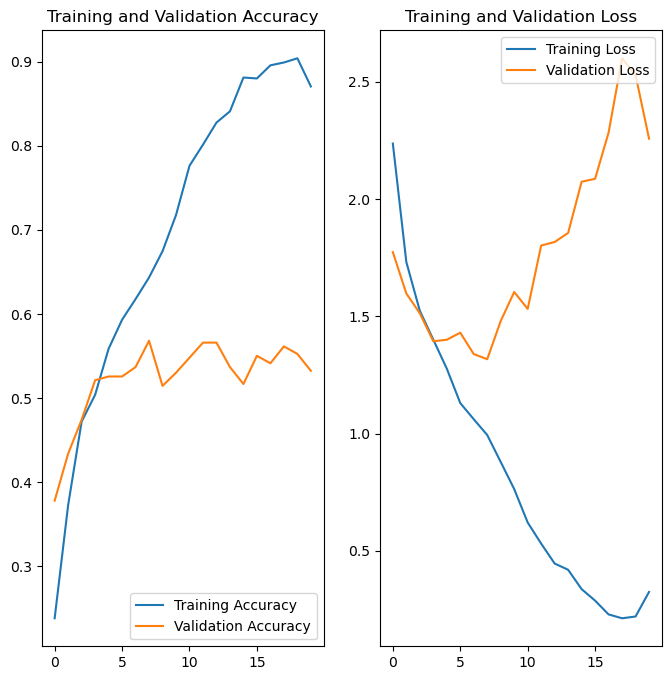

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After adding dropout layer in network, we can observe that there is a slight change in the accuracy gap between training and validation. But still model is overfitting on training data.

### Data distribution analysis:

After adding regularization to the network still the overfitting problem is not solved. So we will analyze the data distribution for classes from training data to take necessary action.

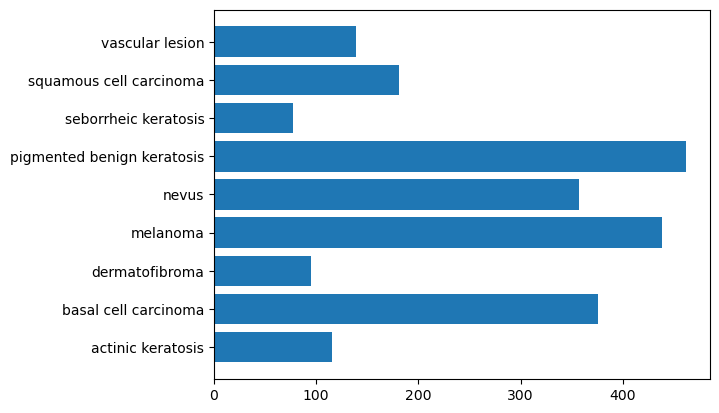

In [117]:
## Your code goes here.
num_images_classes = []
for class_name in class_names:
    num_images_class = len(os.listdir(os.path.join(Train_data_path,class_name)))
    num_images_classes.append(num_images_class)
plt.barh(range(len(num_images_classes)), num_images_classes, tick_label=class_names)
plt.show()

#### Findings fromn training Data distribution : 
From the plot shown above there is a significant imbalance in class distribution 
 - 'seborrheic keratosis' class has least number of training samples.
 - 'pigmented benign keratosis' class dominating other classes in terms of number of training samples.


### Augmentor for class balancing:
To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [118]:
# For augmentation we are not using rotation of image becuse we are adding keras layer to do that job in model training.
samples_per_class = 608 # All classes will have 608 images after balancing using data augmentation(608 is divisible by 32)
for idx, class_name in enumerate(class_names):
    p = Augmentor.Pipeline(Train_data_path + class_name)
    # Now we add a rotate operation to the pipeline
    #p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
    # Now we add a Horizontal flip operation to the pipeline
    #p.flip_left_right(probability=0.4) # Using at inbuilt model
    # Now we add a vertical flip operation to the pipeline
    #p.flip_top_bottom(probability=0.4) # Using at inbuilt model
    # Now we add a shear operation to the pipeline
    p.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.4)
    p.random_brightness(probability = 0.5, min_factor=0.4, max_factor=0.9)
    p.shear(probability=0.5, max_shear_left=0.5,max_shear_right=0.5)
    p.sample(samples_per_class-num_images_classes[idx]) ## We are making 600 samples per class to make sure that none of the classes are sparse.
    

Initialised with 114 image(s) found.
Output directory set to Skin_cancer_data/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21CC2700B10>: 100%|██████████| 493/493 [00:03<00:00, 132.12 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin_cancer_data/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21CCE0B70D0>: 100%|██████████| 232/232 [00:01<00:00, 132.05 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin_cancer_data/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21CCE0FA650>: 100%|██████████| 513/513 [00:03<00:00, 130.14 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin_cancer_data/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x21BD78A7A10>: 100%|██████████| 170/170 [00:09<00:00, 17.44 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to Skin_cancer_data/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3872x2592 at 0x21CCE16D010>: 100%|██████████| 251/251 [00:11<00:00, 21.99 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin_cancer_data/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21CC270F7D0>: 100%|██████████| 146/146 [00:01<00:00, 118.00 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin_cancer_data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x21BEA6AE4D0>: 100%|██████████| 531/531 [00:10<00:00, 52.68 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin_cancer_data/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21BD637A7D0>: 100%|██████████| 427/427 [00:03<00:00, 112.99 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin_cancer_data/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21BEA550D50>: 100%|██████████| 469/469 [00:03<00:00, 120.72 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [128]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

3232


#### Data/class distribution after adding images from augmentation:

In [129]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [130]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [131]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [132]:
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [133]:
lesion_list_original = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train,'*','./', '*.jpg'))]

In [134]:
original_data = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(original_data.items()),columns = ['Path','Label'])

In [135]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [136]:
new_df['Label'].value_counts()

Label
basal cell carcinoma          608
dermatofibroma                608
melanoma                      608
nevus                         608
pigmented benign keratosis    608
seborrheic keratosis          608
squamous cell carcinoma       608
vascular lesion               608
actinic keratosis             607
Name: count, dtype: int64

So, now we have added augmented images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Dataset preparation after balancing:

In [137]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [138]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Train_data_path,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5471 files belonging to 9 classes.
Using 4377 files for training.


#### Create a validation dataset

In [139]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Train_data_path,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5471 files belonging to 9 classes.
Using 1094 files for validation.


### Build model_v3:

After data balancing build new model with batchnormalization layers. And train with balance data.

In [140]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model_v3 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),

  tf.keras.layers.Rescaling(1./255),
    
  tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),# non trainable mute at inference
  tf.keras.layers.RandomRotation(0.25), # non trainable mute at inference
  
  tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])



#### Compile model:

In [141]:

model_v3.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model_v3.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_25 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_23 (RandomFlip)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_23              │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 2048)           │    63,440,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,518,185 (246.12 MB)

 Trainable params: 64,518,185 (246.12 MB)

 Non-trainable params: 0 (0.00 B)

####  Train your model_v3

In [40]:
epochs = 40
history = model_v3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 131s 941ms/step - accuracy: 0.2090 - loss: 2.2622 - val_accuracy: 0.4141 - val_loss: 1.4991
Epoch 2/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 127s 923ms/step - accuracy: 0.4216 - loss: 1.5432 - val_accuracy: 0.4433 - val_loss: 1.4173
Epoch 3/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 920ms/step - accuracy: 0.4622 - loss: 1.4447 - val_accuracy: 0.4561 - val_loss: 1.3500
Epoch 4/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 917ms/step - accuracy: 0.4855 - loss: 1.3690 - val_accuracy: 0.4808 - val_loss: 1.3000
Epoch 5/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 920ms/step - accuracy: 0.4926 - loss: 1.3214 - val_accuracy: 0.5137 - val_loss: 1.2626
Epoch 6/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 127s 928ms/step - accuracy: 0.5053 - loss: 1.3202 - val_accuracy: 0.4899 - val_loss: 1.3635
Epoch 7/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 919ms/step - accuracy: 0.5022 - loss: 1.3300 - val_accuracy: 0.5174 - val_loss: 1.2493
Epoch 8/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 126s 920ms/step - accuracy: 0.5230 -

In [43]:
model_v3.save("model_v3.keras")
model_v3.save_weights("model_v3.weights.h5")

#### Visualize the model results:

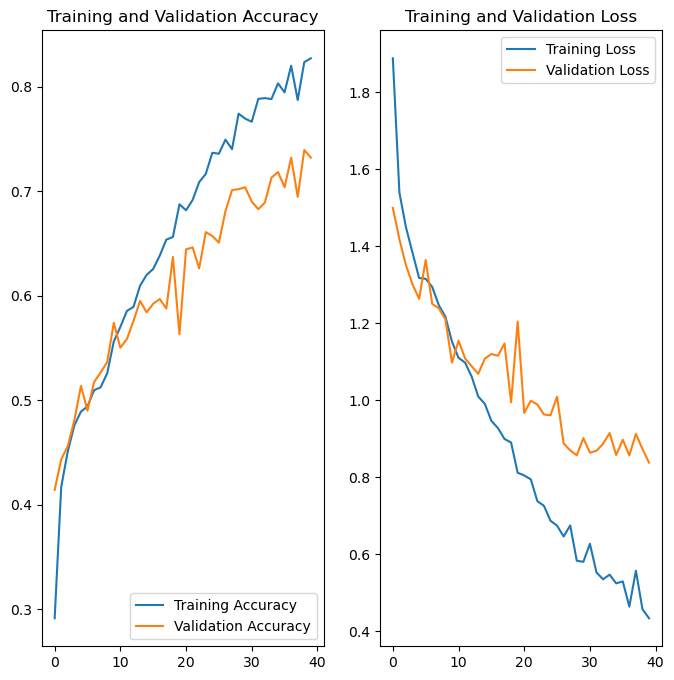

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings from model_v3:
 - After data balancing with augmentation number of samples for all classes are 600.
 - From the accuracy and loss plots we can observe that there is a significant improvement in model performance.
 - Also model overfitting/underfitting got reduced from model_v2 to model_v3

### Model inference:

Upto now we are concentrated on model building and training. Also we have tuned many parameters like augmentation, learning rate number of layers etc. Finally we got a good model which is not overfitting on training data and not underfitting.

Now lets test our model on unseen data to check the performance.

In [55]:
# Dataset for Testing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Test_data_path,
    labels='inferred',
    label_mode='int', #'categorical',
    color_mode='rgb',
    batch_size=1,
    image_size=(img_height, img_width),
    interpolation='bilinear',
    data_format= 'channels_last',
    verbose=True
)

Found 118 files belonging to 9 classes.


In [73]:
predictions = []
labels =  []
for x, y in test_ds:
    idx_max = np.argmax(model_v4.predict(x))
    predictions.append(class_names[idx_max])
    labels.append(class_names[y.numpy()[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [74]:
from sklearn import metrics
metrics.confusion_matrix(labels, predictions, labels=class_names)

array([[ 3,  4,  0,  1,  4,  3,  1,  0,  0],
       [ 1, 11,  1,  1,  0,  1,  0,  1,  0],
       [ 1,  5,  4,  2,  1,  3,  0,  0,  0],
       [ 0,  2,  0,  3, 11,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 14,  1,  0,  0,  0],
       [ 0,  7,  0,  1,  1,  7,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  3,  1,  2,  3,  1,  0,  5,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3]], dtype=int64)

In [75]:
metrics_cancer = metrics.classification_report(labels, predictions,labels=class_names ,output_dict=True)
metrics_cancer_df = pd.DataFrame(metrics_cancer).transpose()
#metrics_cancer_df.drop(["macro avg","weighted avg"], axis=1)
metrics_cancer_df

,precision,recall,f1-score,support
actinic keratosis,0.600000,0.187500,0.285714,16.000000
basal cell carcinoma,0.343750,0.687500,0.458333,16.000000
dermatofibroma,0.666667,0.250000,0.363636,16.000000
melanoma,0.214286,0.187500,0.200000,16.000000
nevus,0.411765,0.875000,0.560000,16.000000
pigmented benign keratosis,0.437500,0.437500,0.437500,16.000000
seborrheic keratosis,0.000000,0.000000,0.000000,3.000000
squamous cell carcinoma,0.833333,0.312500,0.454545,16.000000
vascular lesion,0.750000,1.000000,0.857143,3.000000
accuracy,0.423729,0.423729,0.423729,0.423729


#### Observations from predictions:

 - The over all accuracy for model is very low, becuase the test dataset has very limited number of samples. We can make a conclusion on test accuracy if there are significant amount of test samples are available.
 - The classes 'actinic keratosis', 'melanoma', 'seborrheic keratosis' are having very poor accuracy, recall numbers.
Lets try to improve model performance by tuning model parameters in next versions.

### Build model_v4:

 - Changing thirm maxpool layer size from 2 to 3 to retain corner features

In [142]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model_v4 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),

  tf.keras.layers.Rescaling(1./255),
    
  tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),# non trainable mute at inference
  tf.keras.layers.RandomRotation(0.25), # non trainable mute at inference
  
  tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=2),
  
  tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=2),

  tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=3),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])



In [143]:
## your code goes here

### Todo, choose an appropirate optimiser and loss function
model_v4.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model_v4.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_26 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_24 (RandomFlip)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_24              │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 2048)           │    29,493,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,570,537 (116.62 MB)

 Trainable params: 30,570,537 (116.62 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
## Your code goes here, note: train your model for 20 epochs
epochs = 50

history = model_v4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)## your training code

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 556ms/step - accuracy: 0.2398 - loss: 1.9681 - val_accuracy: 0.4141 - val_loss: 1.4875
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 557ms/step - accuracy: 0.4245 - loss: 1.5533 - val_accuracy: 0.4132 - val_loss: 1.4696
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 75s 549ms/step - accuracy: 0.4554 - loss: 1.4355 - val_accuracy: 0.4232 - val_loss: 1.5285
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 551ms/step - accuracy: 0.4606 - loss: 1.4249 - val_accuracy: 0.4634 - val_loss: 1.3757
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 553ms/step - accuracy: 0.4977 - loss: 1.3391 - val_accuracy: 0.4835 - val_loss: 1.2856
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 551ms/step - accuracy: 0.5167 - loss: 1.2927 - val_accuracy: 0.5073 - val_loss: 1.2821
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 551ms/step - accuracy: 0.5254 - loss: 1.2443 - val_accuracy: 0.4826 - val_loss: 1.2848
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 555ms/step - accuracy: 0.5291 - loss: 1

137/137 ━━━━━━━━━━━━━━━━━━━━ 77s 561ms/step - accuracy: 0.8527 - loss: 0.3840 - val_accuracy: 0.7404 - val_loss: 0.8001


In [57]:
predictions = []
labels =  []
for x, y in test_ds:
    idx_max = np.argmax(model_v4.predict(x))
    predictions.append(class_names[idx_max])
    labels.append(class_names[y.numpy()[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [58]:
from sklearn import metrics
metrics.confusion_matrix(labels, predictions, labels=class_names)

array([[ 5,  2,  1,  0,  5,  2,  1,  0,  0],
       [ 2,  8,  2,  1,  0,  3,  0,  0,  0],
       [ 1,  1,  5,  0,  3,  4,  1,  1,  0],
       [ 0,  1,  0,  4, 10,  1,  0,  0,  0],
       [ 0,  0,  0,  3, 12,  1,  0,  0,  0],
       [ 1,  5,  1,  1,  0,  7,  0,  1,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 1,  3,  0,  2,  2,  2,  0,  5,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  2]], dtype=int64)

In [59]:
metrics_cancer = metrics.classification_report(labels, predictions,labels=class_names ,output_dict=True)
metrics_cancer_df = pd.DataFrame(metrics_cancer).transpose()
#metrics_cancer_df.drop(["macro avg","weighted avg"], axis=1)
metrics_cancer_df

,precision,recall,f1-score,support
actinic keratosis,0.500000,0.312500,0.384615,16.00000
basal cell carcinoma,0.400000,0.500000,0.444444,16.00000
dermatofibroma,0.555556,0.312500,0.400000,16.00000
melanoma,0.285714,0.250000,0.266667,16.00000
nevus,0.375000,0.750000,0.500000,16.00000
pigmented benign keratosis,0.333333,0.437500,0.378378,16.00000
seborrheic keratosis,0.000000,0.000000,0.000000,3.00000
squamous cell carcinoma,0.714286,0.312500,0.434783,16.00000
vascular lesion,0.666667,0.666667,0.666667,3.00000
accuracy,0.406780,0.406780,0.406780,0.40678


### Observations from model_v4:

 - Model is not overfitting/underfitting because the accuracy of training and validation are not too far.
 - The test results are still poor but there is a slight change in results.

Lets understand samples from "melanoma", "nevus" becuase in above models the prediction results shows that both these classes are overlapping each other (from confusion matrix)
    

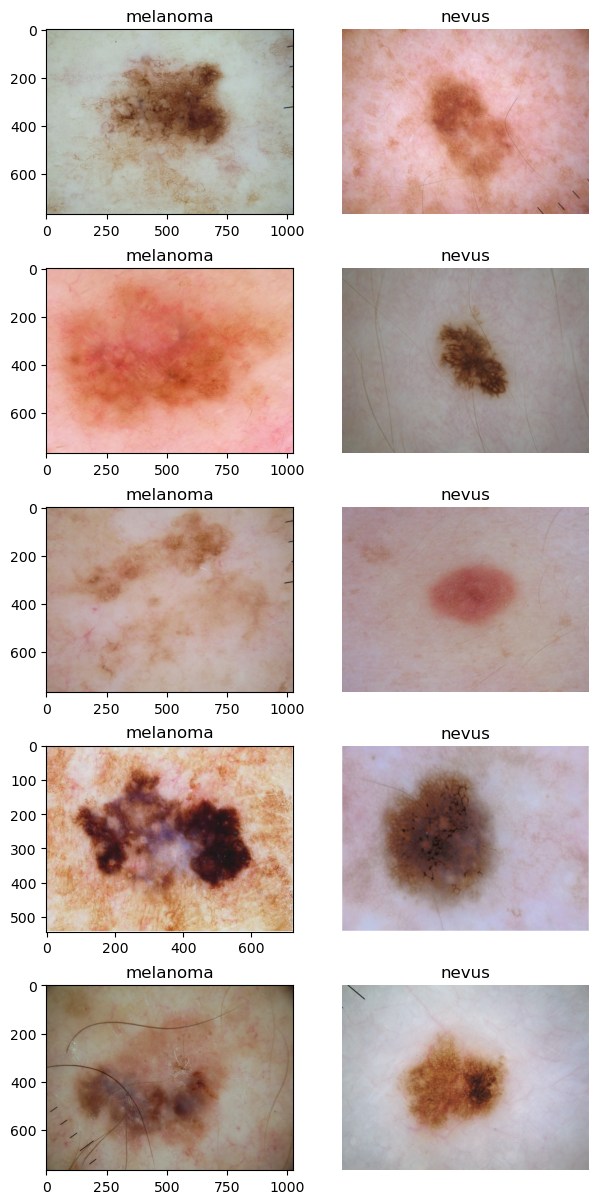

In [147]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7, 15))
for i in range(5):

  ax = plt.subplot(5, 2, i*2 + 1)
  filenames = os.listdir(os.path.join(Train_data_path, "melanoma"))  #, "nevus"
  image = Image.open(os.path.join(Train_data_path, "melanoma",random.choice(filenames) ))
  plt.imshow(np.array(image))
  plt.title("melanoma")
    
  ax = plt.subplot(5, 2, i*2 + 2)
  filenames = os.listdir(os.path.join(Train_data_path, "nevus"))  #, "nevus"
  image = Image.open(os.path.join(Train_data_path, "nevus",random.choice(filenames) ))
  plt.imshow(np.array(image))
  plt.title("nevus")

  plt.axis("off")
    
    

#### Observations from above figures:
 - As we can observe from images from both classes 'melanoma', 'nevus' both skin images are most similar to each other.
 - So the model is unable to classify between both of this classes.

## Conclusions:
 - We started with simple basic convolution model with 3 layers followed by 2 fully connected layers and output layer. And observed that model is overfitting on training data.
 - In model_v2 we have added a dropout layer to avoid overfitting problem at fully connected layer. And observed that there is little improvement compared with actual model_v1.
 - Next, we analyzed data/sample distribution of all classes and found that there a class imbalance in dataset. By using an augmenter library, we have balanced our dataset.
 - After balancing the data, we trained our model_v3 and found that there is a significant improvement in training and validation accuracy.
 - But the model prediction is not as expected. So, we have built another model_v4 by changing maxpool layer size. But even if we train the model for 50 epochs the test accuracy for model is not good enough.
 - To improve the test accuracy we need to test our model on large amount of test datasets to make conclusions.
 - There is a similarity observed between two classes **"melanoma"**, **"nevus"**, that is the reason why every model is predicting melanoma as nevus and vice versa.
